In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 8.677 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info  

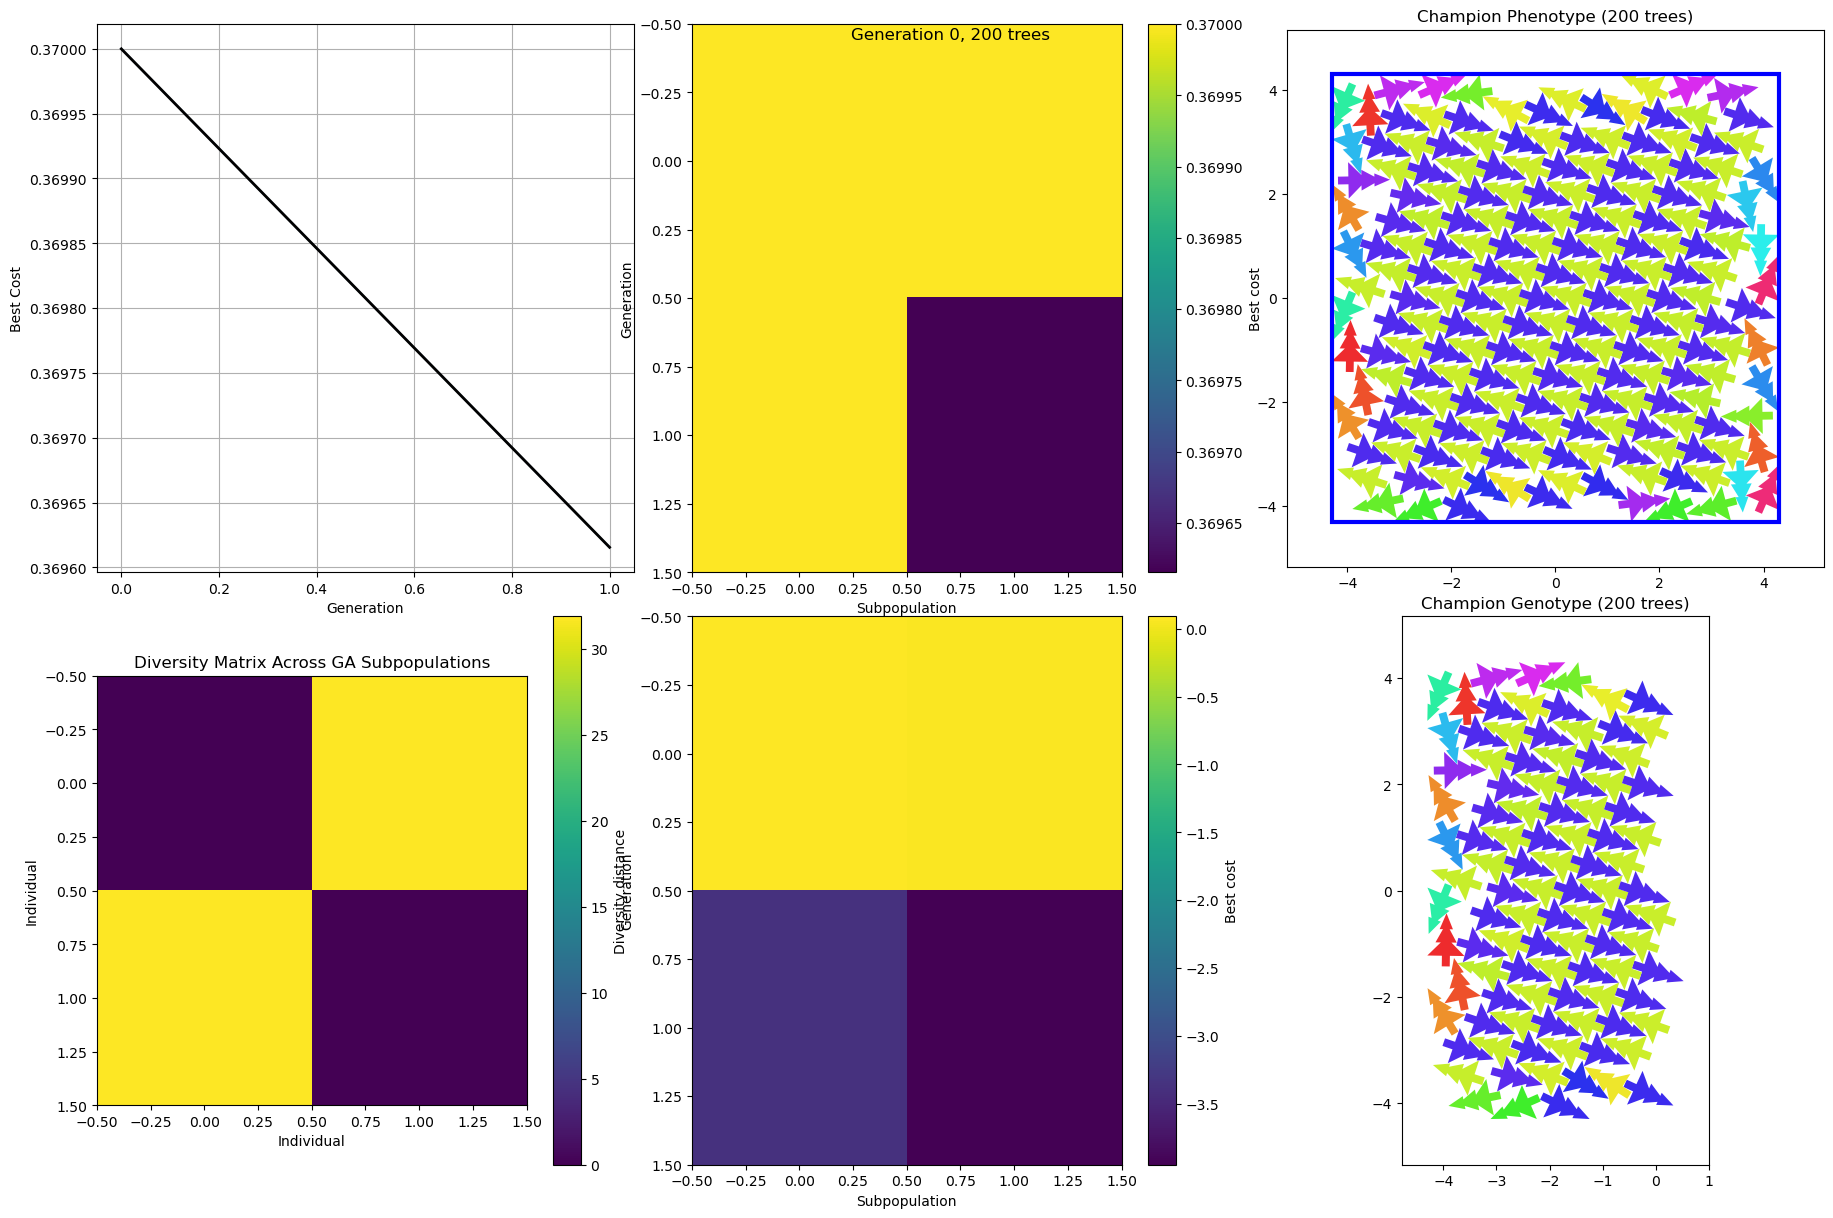

In [2]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 1

runner = pack_ga3.baseline_symmetry_180()
runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Perfect dimer'
runner.ga.ga_base.initializer.ref_sol_axis1_offset = 0.
runner.ga.ga_base.initializer.ref_sol_axis2_offset = 0.5
runner.ga.ga_base.initializer.new_tree_placer = True
runner.ga.ga_base.initializer.base_solution.edge_spacer = kgs.EdgeSpacerBasic(dist_x = 0.75, dist_y = 0.5)
runner.ga.ga_base.initializer.base_solution.filter_move_locations_with_edge_spacer = True

runner.ga.N = 2
runner.ga.ga_base.N_trees_to_do = 200
runner.n_generations = 1
runner.diagnostic_plot = True
runner.seed = 0
runner.plot_every = 1
runner.ga.do_legalize = False

runner.run()

In [3]:
pop = runner.ga.ga_list[0].champions[0]
pop.merge(runner.ga.ga_list[1].champions[0])

[CrossoverStripe(comment='', min_N_trees=2, max_N_trees_ratio=0.5, jitter=0.0, distance_function='stripe', decouple_mate_location=False, use_edge_clearance_when_decoupled=True, do_rotation=False), 'CrossoverStripe', 2.0]
[-3.4661503] [3.151538]


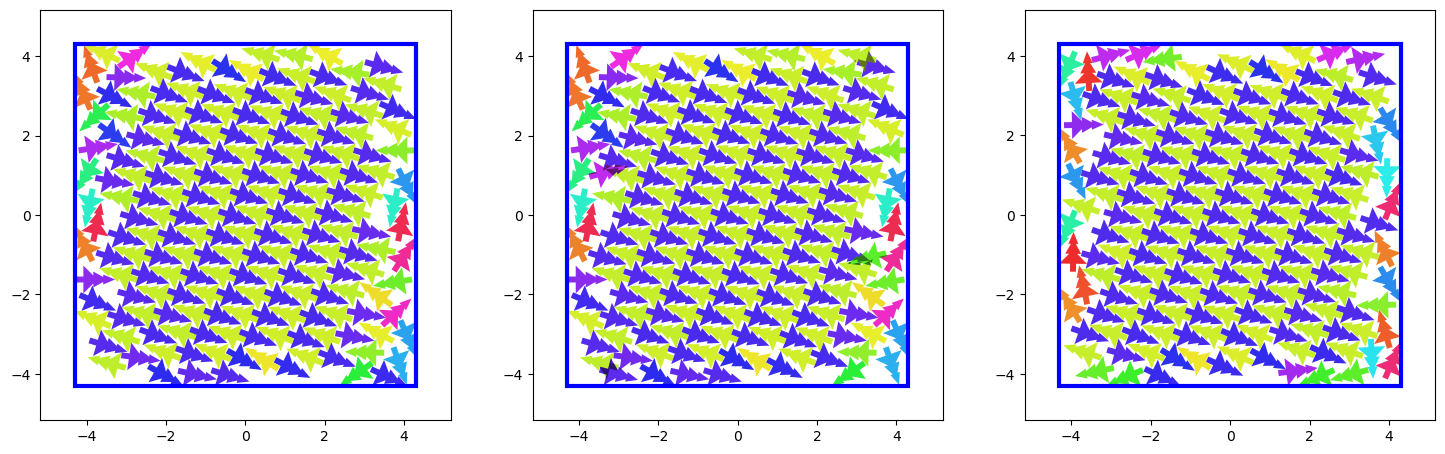

[-1.8029183] [3.8432255]


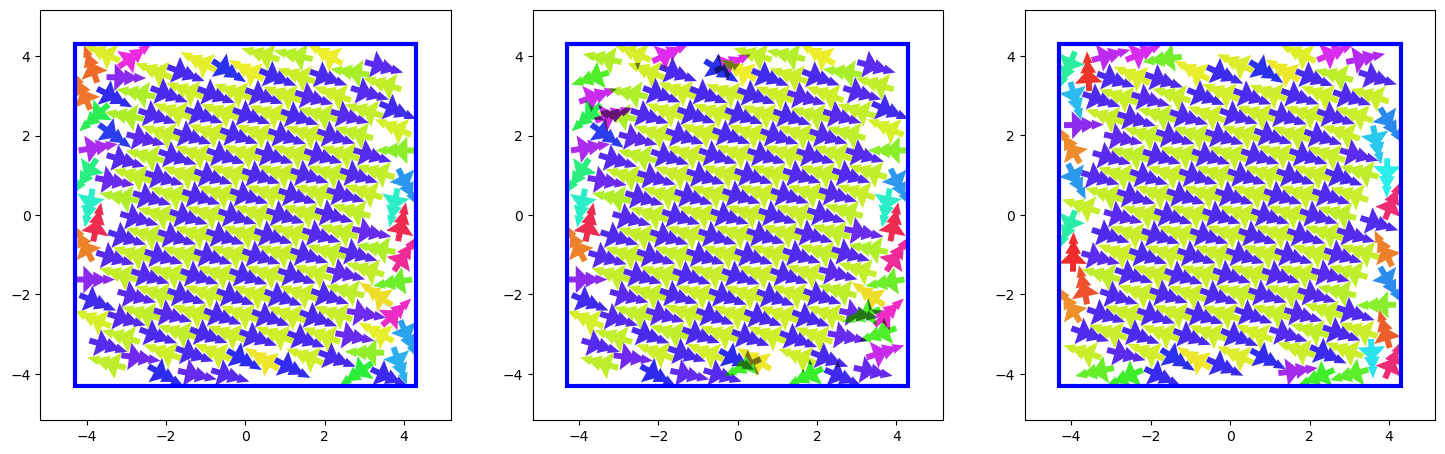

[-4.2943187] [0.55689275]


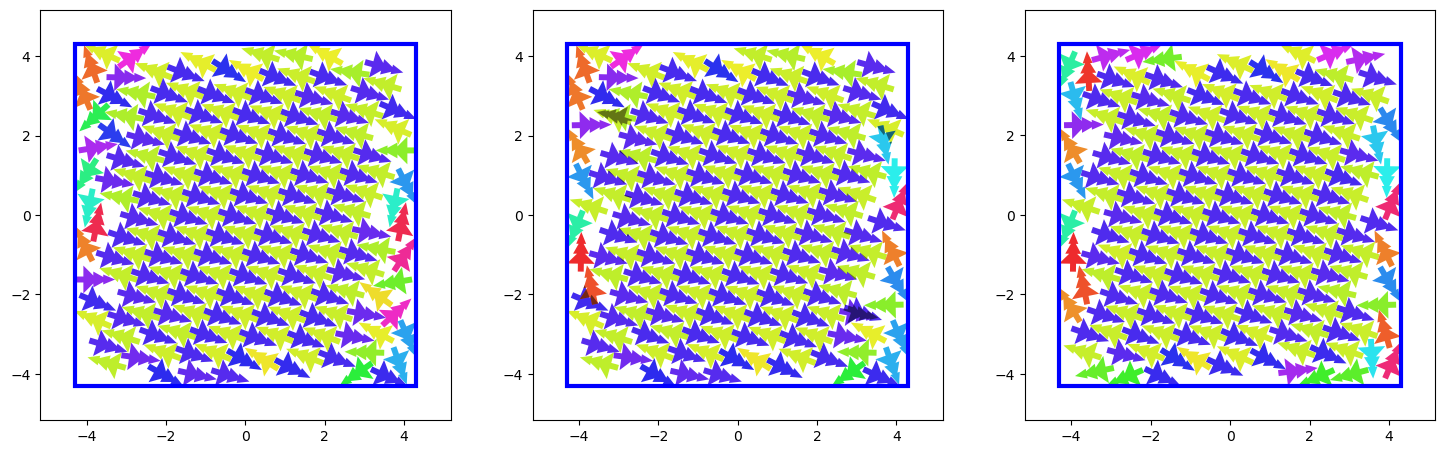

[-3.5064197] [1.6170983]


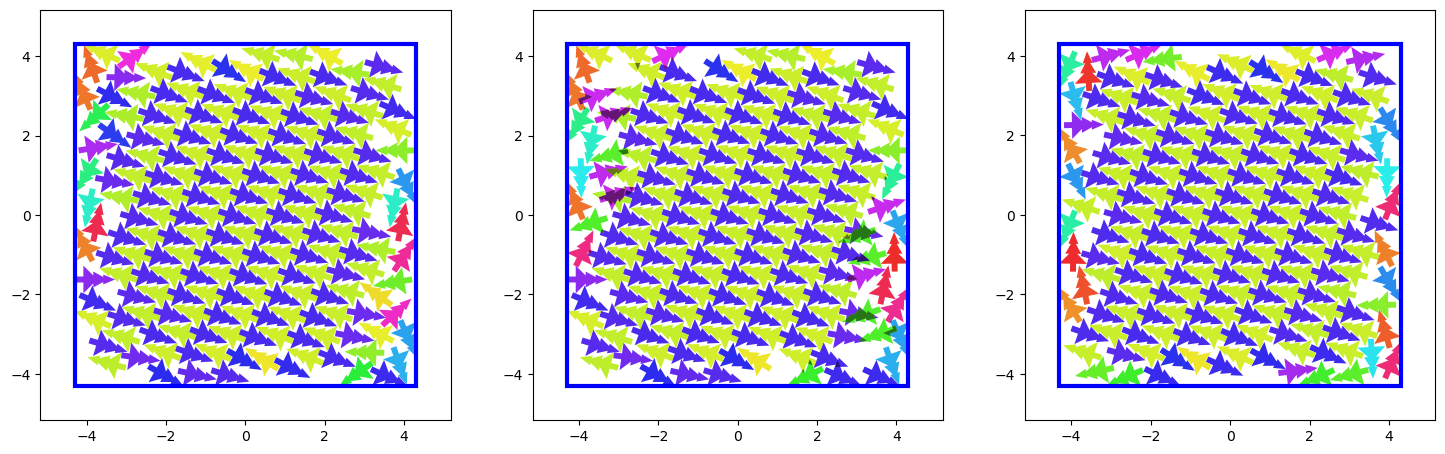

[-4.132417] [2.6915212]


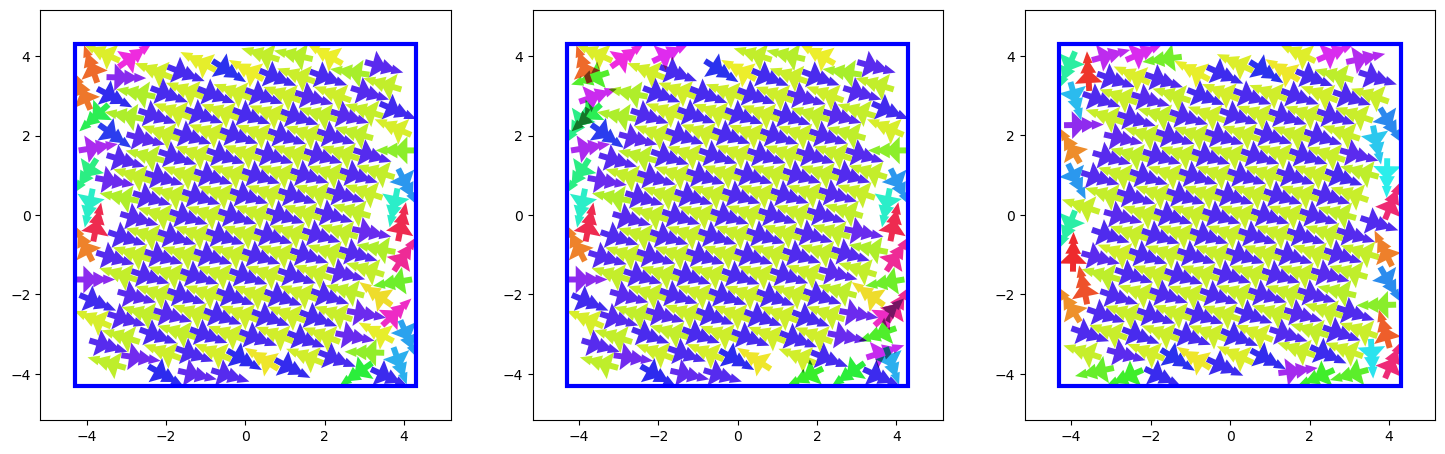

[-3.931535] [3.4251423]


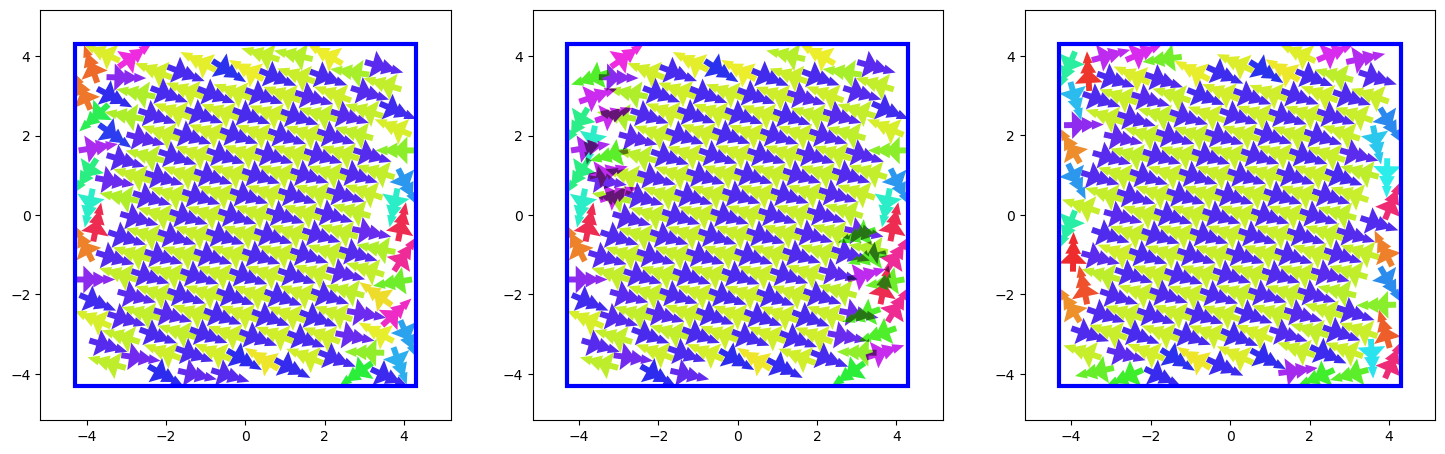

[-3.5207994] [-3.7351725]


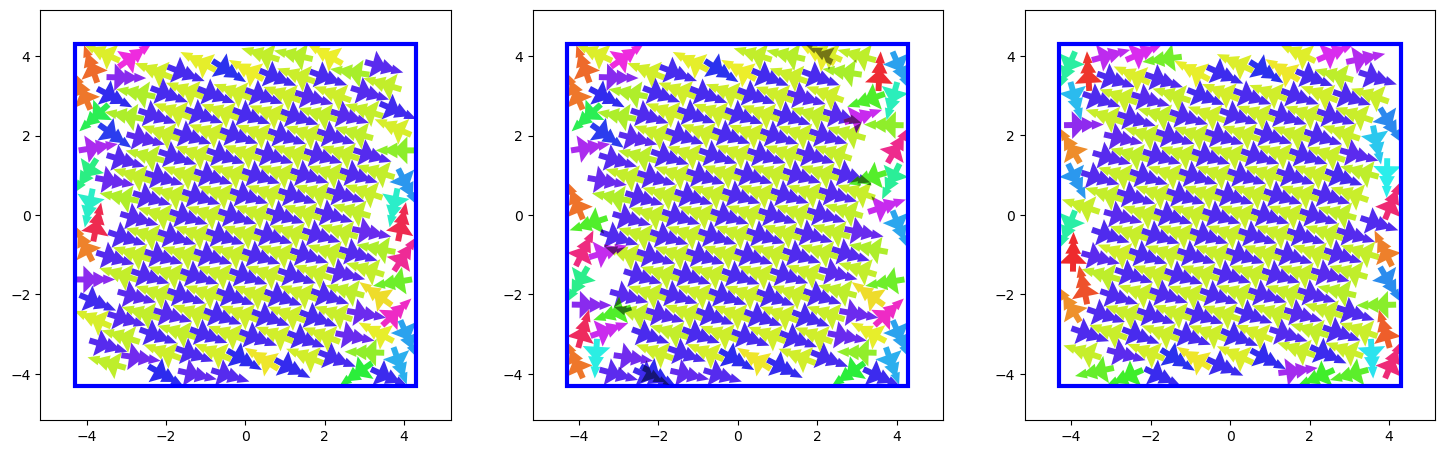

[-3.753577] [-2.3882804]


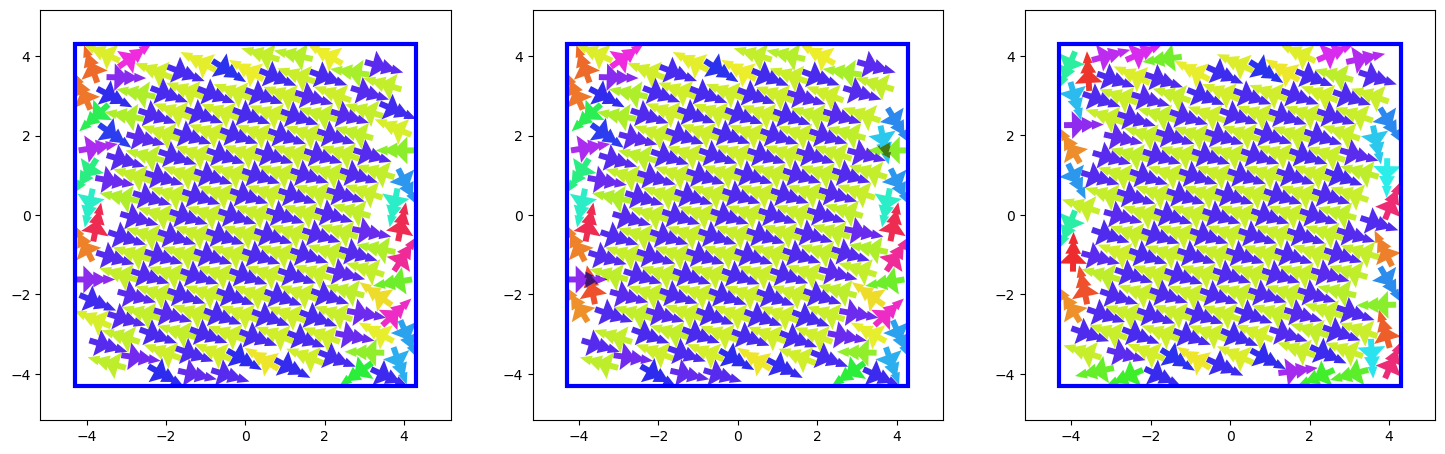

[-3.504937] [1.7774813]


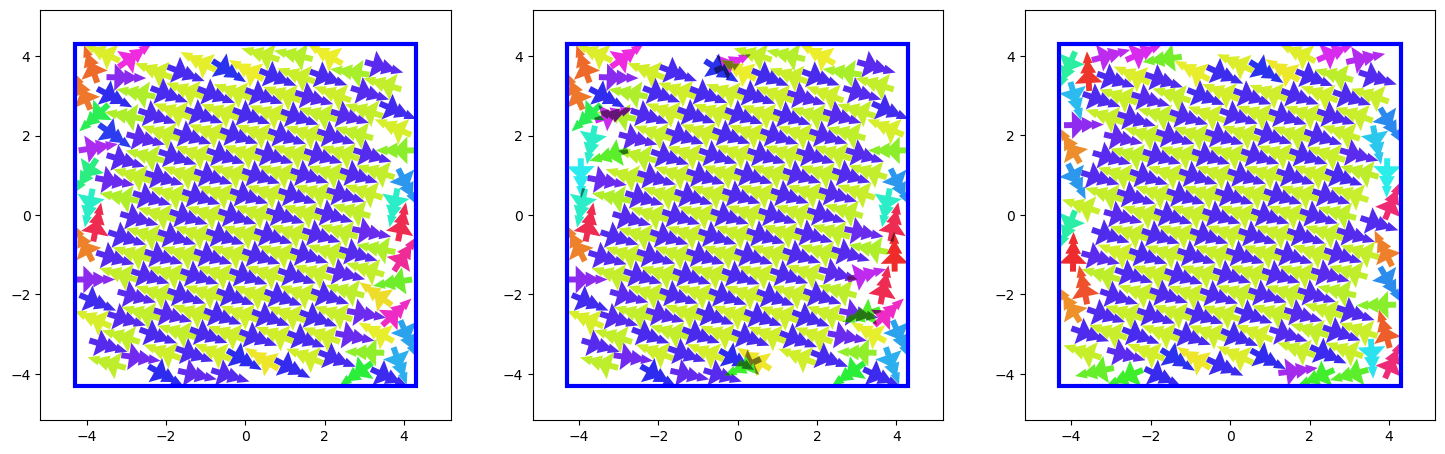

[-3.1512842] [-3.3913054]


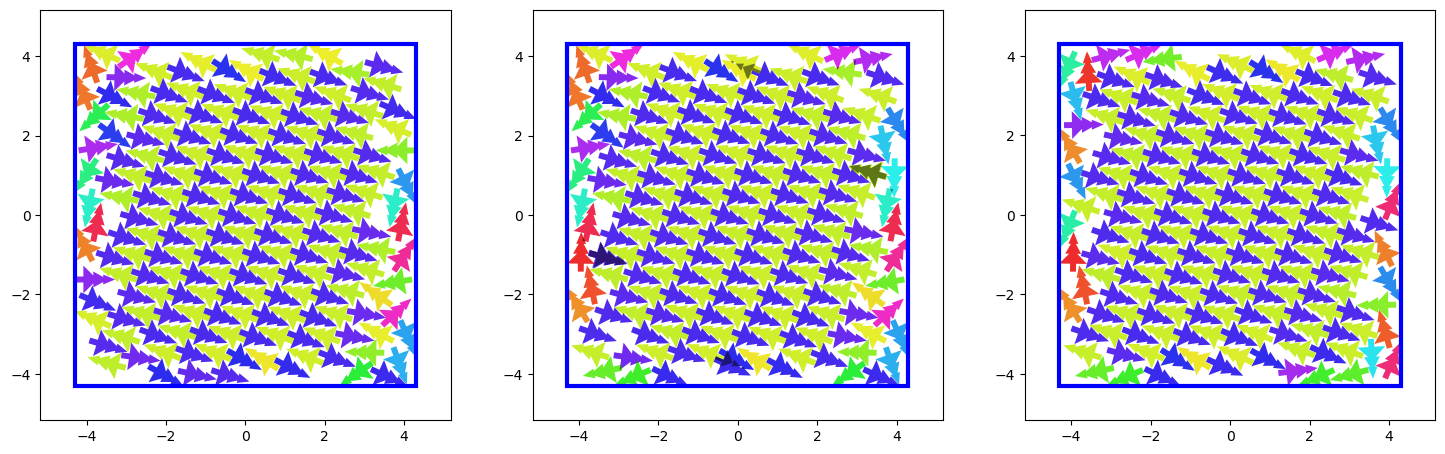

In [ ]:
import pack_ga3
import pack_move
import pack_vis_sol
importlib.reload(pack_move)
move = runner.ga.ga_base.move.moves[6]
move[0].do_rotation = False
move[0].respect_edge_spacer_filter = False
#move[0].use_edge_clearance_when_decoupled = False
#move[0].max_N_trees_ratio= 0.2
print(move)
move = move[0]
#move.jitter = 0.
#move = pack_move.CrossoverStripe()
#move.distance_function = 'square90'
#move.decouple_mate_location = True
#move.distance_function = 'stripe'
#move.min_N_trees = 25
generator = cp.random.default_rng(seed=12345)
for _ in range(10):
    pop_here = copy.deepcopy(pop)
    pop_here.genotype.filter_move_locations_with_edge_spacer = True
    move.do_move_vec(pop_here, cp.array([0]), pop_here.genotype, cp.array([1]), generator)
    pop_here.genotype.canonicalize()
    #print(move_descriptor)
    # fig,ax = plt.subplots(1,3,figsize=(18,6))
    # plt.sca(ax[0])
    # pack_vis_sol.pack_vis_sol(pop.genotype, ax=ax[0], solution_idx=0)
    # plt.sca(ax[1])
    # pack_vis_sol.pack_vis_sol(pop_here.genotype, ax=ax[1], solution_idx=0)
    # plt.sca(ax[2])
    # pack_vis_sol.pack_vis_sol(pop.genotype, ax=ax[2], solution_idx=1)
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    plt.sca(ax[0])
    pack_vis_sol.pack_vis_sol(pop.genotype.convert_to_phenotype(), ax=ax[0], solution_idx=0)
    plt.sca(ax[1])
    pack_vis_sol.pack_vis_sol(pop_here.genotype.convert_to_phenotype(), ax=ax[1], solution_idx=0)
    plt.sca(ax[2])
    pack_vis_sol.pack_vis_sol(pop.genotype.convert_to_phenotype(), ax=ax[2], solution_idx=1)
    plt.pause(0.001)
    # pack_vis.visualize_tree_list(tree_list, ax=ax[0])
    # plt.sca(ax[1])
    # tree_list = kgs.TreeList()
    # tree_list.xyt = pop_here.genotype.xyt[0].get()
    # pack_vis.visualize_tree_list(tree_list, ax=ax[1])
    # plt.sca(ax[2])
    # tree_list = kgs.TreeList()
    # tree_list.xyt = pop_here.genotype.xyt[1].get()
    # pack_vis.visualize_tree_list(tree_list, ax=ax[2])
    # plt.pause(0.001)